In [287]:
import scipy.stats.stats
import sys; sys.path.insert(0, '../../');
from methods.config import *
import os
import matplotlib.pyplot as plt
import numpy as np; rnd = np.random.default_rng()
import pickle
from importlib import reload
import copy

import methods.util as util
import methods.breseq_util as breseq
import methods.shared as shared
reload(breseq)

with open(f'{data_dir}/barcode_clone_map.pkl', 'rb') as f:
    barcode_clone_map = pickle.load(f)

with open(f'{data_dir}/clone_barcode_map.pkl', 'rb') as f:
    clone_barcode_map = pickle.load(f)

with open(f'{data_dir}/mouse_clone_map.pkl', 'rb') as f:
    mouse_clone_map = pickle.load(f)

with open(f'{data_dir}/pickled/preexisting_variants.pkl', 'rb') as f:
    exclude_muts = pickle.load(f)

with open(f'{data_dir}/pickled/vitro_array.pkl', 'rb') as f:
    vitro_array = pickle.load(f)
    vitro_freqs = vitro_array / np.sum(vitro_array, axis=1).reshape(-1,1)

with open(f'{data_dir}/pickled/vitro_meta.pkl', 'rb') as f:
    vitro_meta = pickle.load(f)

with open(f'{data_dir}/pickled/vitro_col_map.pkl', 'rb') as f:
    vitro_col_map = pickle.load(f)

isolate_gd_dir = f'{data_dir}/clone_seq/E1_clones_gd_annotated'
gd_files = os.listdir(isolate_gd_dir)

ordered_barcodes = [(barcode, clones['all']) for barcode, clones in barcode_clone_map.items() if len(barcode) == 20]
ordered_barcodes.sort(key = lambda x:len(x[1]), reverse=True)

In [288]:
gd_directory = '/Volumes/KAIRI/invitro_gd/'

well_passage_to_file_name = {}
for vitro_set in ['S1_annotated', 'S2_annotated', 'S3_annotated',
            'S4_annotated', 'S5_annotated', 'S6_annotated']:
    set_files = os.listdir(gd_directory+vitro_set)
    for file in set_files:
        if '.gd' not in file or 'd0' in file:
            continue
        file_split = file.split('_')
        passage = int(file_split[2].replace('passage', ''))
        well = f'{file_split[3]}_{file_split[4].replace("_annotated.gd", "")}'

        if well in ['p2_E3', 'p2_F3', 'p2_G3', 'p2_H3']:
            continue

        well_passage_to_file_name[(well, passage)] = f'{gd_directory}{vitro_set}/{file}'

print(well_passage_to_file_name)


{('p1_A1', 15): '/Volumes/KAIRI/invitro_gd/S1_annotated/metagenome_invitro_passage15_p1_A1__annotated.gd', ('p1_A5', 15): '/Volumes/KAIRI/invitro_gd/S1_annotated/metagenome_invitro_passage15_p1_A5_annotated.gd', ('p1_A9', 15): '/Volumes/KAIRI/invitro_gd/S1_annotated/metagenome_invitro_passage15_p1_A9_annotated.gd', ('p1_C1', 15): '/Volumes/KAIRI/invitro_gd/S1_annotated/metagenome_invitro_passage15_p1_C1__annotated.gd', ('p1_C5', 15): '/Volumes/KAIRI/invitro_gd/S1_annotated/metagenome_invitro_passage15_p1_C5_annotated.gd', ('p1_C9', 15): '/Volumes/KAIRI/invitro_gd/S1_annotated/metagenome_invitro_passage15_p1_C9_annotated.gd', ('p1_E1', 15): '/Volumes/KAIRI/invitro_gd/S1_annotated/metagenome_invitro_passage15_p1_E1__annotated.gd', ('p1_E5', 15): '/Volumes/KAIRI/invitro_gd/S1_annotated/metagenome_invitro_passage15_p1_E5_annotated.gd', ('p1_G1', 15): '/Volumes/KAIRI/invitro_gd/S1_annotated/metagenome_invitro_passage15_p1_G1__annotated.gd', ('p1_G5', 15): '/Volumes/KAIRI/invitro_gd/S1_annot

In [289]:
def filter_mutations_in_sample(all_mutations_dict, sample, evidence, preexisting_variants, exclude_genes={},
                                SV_MIN_FREQ=0.5, SV_MIN_SIZE=10, SV_MIN_COV=5, polymorphism_min=-1):
    DEL_evidence = evidence['DEL']
    SNP_evidence = evidence['SNP']
    SUB_evidence = evidence['SUB']
    INS_evidence = evidence['INS']
    JC_evidence = evidence['JC']
    MC_evidence = evidence['MC']
    RA_evidence = evidence['RA']

    for evidence_type, evidence in zip(['SNP', 'SUB', 'DEL', 'INS', 'RA'], [SNP_evidence, SUB_evidence, DEL_evidence, INS_evidence, RA_evidence]):
        for mut in evidence:
            position, _, mut_dict = mut
            mut_information = [mut_dict[key] for key in ['gene', 'strand', 'gene_description', 'PUL', 'mutation','mutation_description', 'syn']]
            
            variant_type = mut_dict['mutation_category']

            if polymorphism_min >= 0:
                freq = mut_dict['frequency']
                if freq < polymorphism_min:
                    continue
            else:
                freq = 1

            key = tuple([position, variant_type] + mut_information)
            if breseq.check_preexisting(key, preexisting_variants, exclude_genes=exclude_genes):
                continue
            if evidence_type == 'RA' and key in all_mutations_dict and sample in all_mutations_dict[key]:  #implies already called as SNP/SUB/DEL/INS, so don't double count
                continue
            elif evidence_type == 'RA': #flag as ~low-confidence RA
                key = tuple([position, 'RA'] + mut_information)

            if key not in all_mutations_dict:
                all_mutations_dict[key] = {}
  
            all_mutations_dict[key][sample] = freq

    for mut in JC_evidence:
        (start, end), genes, orientations, freq, JC_coverage = mut
        if freq < SV_MIN_FREQ or end-start < SV_MIN_SIZE or JC_coverage < SV_MIN_COV:
            continue

        key = ((start, end), 'JC', genes, orientations)
        if breseq.check_preexisting(key, preexisting_variants, exclude_genes=exclude_genes):
            continue

        if key not in all_mutations_dict:
            all_mutations_dict[key] = {}
        all_mutations_dict[key][sample] = (freq, JC_coverage)

    for mut in MC_evidence:
        (start, end), genes = mut
        if (end - start) < SV_MIN_SIZE:
            continue

        key = ( (start, end), 'MC', genes )
        if breseq.check_preexisting(key, preexisting_variants, exclude_genes=exclude_genes):
            continue

        if key not in all_mutations_dict:
            all_mutations_dict[key] = {}
        all_mutations_dict[key][sample] = 0

In [323]:
reload(breseq)
track_RA = False
SV_MIN_FREQ = 0.0
SV_MIN_SIZE = 10
SV_MIN_COV = 5
SNP_MIN_FREQ  = 0.0

n_clones = 0
clone_evidence_map = {}

well_mutations_map = {medium:{well:{} for (well, invitro_set) in shared.medium_to_well_map[medium]} \
                      for medium in shared.medium_to_well_map.keys()}
all_mutations_in_vitro = {}

for well_passage, file in well_passage_to_file_name.items():
    well, passage = well_passage
    medium, invitro_set = shared.well_to_medium_map[well]

    coverage, sample_evidence = breseq.get_variants_from_annotated_gd_file(file, freq=True, track_RA=track_RA)

    well_mutations_map[medium][well][passage] = {'coverage':coverage, 'evidence':sample_evidence}

    ## filter
    filter_mutations_in_sample(all_mutations_in_vitro, (well, passage), sample_evidence, exclude_muts, 
                                SV_MIN_FREQ=SV_MIN_FREQ, SV_MIN_SIZE=SV_MIN_SIZE, SV_MIN_COV=SV_MIN_COV, polymorphism_min=SNP_MIN_FREQ)
    
# JC_list = sorted([(mut, well_passages) for mut, well_passages in all_mutations_in_vitro.items() if mut[1] == 'JC'], key=lambda x:x[0][0])
# for i, (mut, mut_clones) in enumerate(JC_list[:-1]):
#     mut_start, mut_stop = mut[0]
#     mut_orientations = np.array(mut[-1])

#     for (next_mut, next_clones) in JC_list[i+1:]:
#         next_start, next_stop = next_mut[0]
#         next_orientations = np.array(next_mut[-1])

#         if np.abs(mut_start-next_start) < 5 and np.abs(mut_stop - next_stop) < 5 \
#                 and np.all(mut_orientations == next_orientations):
#             for well_passage, (freq, coverage) in next_clones.items():
#                 all_mutations_in_vitro[mut][well_passage] = (freq, coverage)
#             del all_mutations_in_vitro[next_mut]

In [324]:
filtered_well_mutations = {medium:{well:{} for (well, bc_set) in shared.medium_to_well_map[medium]} for medium in shared.ordered_media }

def merge_mutations_in_a_well(filtered_well_mutations, all_in_vitro_mutations):
    mut_flags = {}
    for mut, sample_freq_dict in all_in_vitro_mutations.items():
        samples = list(sample_freq_dict.keys())
        sampled_wells = set(well for (well, passage) in samples)
        
        for (well, passage) in samples:
            medium, bc_set = shared.well_to_medium_map[well]
            if mut not in filtered_well_mutations[medium][well]:
                filtered_well_mutations[medium][well][mut] = {}
            filtered_well_mutations[medium][well][mut][passage] = sample_freq_dict[(well, passage)]

        for well in sampled_wells:
            medium, bc_set = shared.well_to_medium_map[well]

            passage_dict = filtered_well_mutations[medium][well][mut]
            passages_detected = np.array(sorted(passage_dict.keys()))

            max_freq_in_well = []
            for passage in passages_detected:
                if ('vitro', well, passage) in vitro_col_map:
                    max_freq_in_well.append( np.max(vitro_freqs[vitro_col_map[('vitro', well, passage)]]) )
                else:
                    max_freq_in_well.append(1)
            max_freq_in_well = np.array(max_freq_in_well)

            # if mut[1] == 'JC':
            #     mut_freqs = [freq for passage, (freq, coverage) in passage_dict.items()]
            # else:
            #     mut_freqs = [freq for passage, freq in passage_dict.items()]
            # if np.any(np.array(mut_freqs) > 2*max_freq_in_well):
            #     # del filtered_well_mutations[medium][well][mut]
            #     continue

            if 15 not in passage_dict or 31 not in passage_dict:
                del filtered_well_mutations[medium][well][mut]
                continue

            if mut not in mut_flags:
                mut_flags[mut] = True #plausible driver in at least one well

    return filtered_well_mutations, mut_flags

filtered_well_mutations, mut_flags = merge_mutations_in_a_well(filtered_well_mutations, all_mutations_in_vitro

all_mutations = {}
for medium, wells in filtered_well_mutations.items():
    for well, muts in wells.items():
        for mut, passages in muts.items():
            if mut not in mut_flags:
                continue
            if mut not in all_mutations:
                all_mutations[mut] = {}
            for passage, freq in passages.items():
                all_mutations[mut][(well, passage)] = freq  

print(len(all_mutations), 'mutations in total')

101 mutations in total


In [325]:
with open(f'{data_dir}/tables_for_publication/tableS4_invitro_mutations.tsv', 'w') as f:
    header = f'position\tgene\tgene_description\tPUL\tmut_type\tmutation\tfreq. in (Medium, Well)'
    for medium in shared.ordered_media:
        for (well, bc_inoculum) in shared.medium_to_well_map[medium]:
            header += f'\t({medium}, {well})'
    f.write(header+'\n')

    mut_positions = []
    mut_lst = list(all_mutations.keys())
    for mut in mut_lst:
        if type(mut[0]) == int:
            mut_positions.append(mut[0])
        else:
            mut_positions.append(mut[0][0])
    sorting = np.argsort(mut_positions)

    for mutation in np.array(mut_lst)[sorting]:
        mut_type = mutation[1]
        
        
        if mut_type == 'JC':
            loc1, loc2 = mutation[0]
            orient1, orient2 = mutation[-1]

            gene1, gene2 = mutation[2]    

            loc_str = f'{loc1}'
            mut_str = f'{loc1}_{orient1}_{loc2}_{orient2}'

            
            gene_str = ''
            gene_product = ''
            PULs = []
            for i, g in enumerate([gene1, gene2]):
                if i == 1:
                    gene_product += ' - '
                    gene_str += ' - '
                    PULs 
                if '-' in g:
                    g1, g2 = g.split('-')
                    gene_str += f'{g1}/{g2}'
                    gene_product += f'{shared.gene_description[g1]}/{shared.gene_description[g2]}'
                    for g_ in [g1, g2]:
                        if g_ in breseq.gene_PUL_map:
                            PULs.append( str(breseq.gene_PUL_map[g_][0]) )
                else:
                    gene_str += g
                    gene_product += f'{shared.gene_description[g]}'
                    if g in breseq.gene_PUL_map:
                        PULs.append( str(breseq.gene_PUL_map[g][0]) )
            PUL = ''
            if len(PULs) != 0:
                PUL += ','.join(sorted(set(PULs)))

        elif mut_type == 'MC':
            loc1, loc2 = mutation[0]
            gene1, gene2 = mutation[2]    

            loc_str = f'{loc1}'
            gene_str = f'{gene1}-{gene2}'
            mut_str = f'deletion'
            continue

# ['gene', 'strand', 'gene_description', 'PUL', 'mutation','mutation_description', 'syn']]

        else:
            loc_str = f'{mutation[0]}'
            gene_str = f'{mutation[2]}'
            mut_str = f'{mutation[-2]}'
            gene_product = mutation[4]
            PUL = f'{mutation[5]}'

        line = f'{loc_str}\t{gene_str}\t{gene_product}\t{PUL}\t{mut_type}\t{mut_str}\t'
        for medium in shared.ordered_media:
            for (well, bc_inoculum) in shared.medium_to_well_map[medium]:


                if mutation in filtered_well_mutations[medium][well]:
                    trajectory = filtered_well_mutations[medium][well][mutation]
                    sorted_passages = sorted(trajectory.keys())
                    if 'JC' in mut_type:
                        line_items = [f'{passage}:{trajectory[passage][0]:.2f}' for passage in sorted_passages]
                    else:
                        line_items = [f'{passage}:{trajectory[passage]:.2f}' for passage in sorted_passages]
                    line += f'\t{", ".join(line_items)}'
                else:
                    line += f'\t'
        line += '\n'
        f.write(line)

/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_80623/1158282150.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for mutation in np.array(mut_lst)[sorting]:


In [326]:
## Look for overlapping genes between in vitro and in vivo
in_vitro_genes = set()
with open(f'{data_dir}/tables_for_publication/tableS4_invitro_mutations.tsv', 'r') as f:
    header = f.readline()
    for line in f:
        line_split = line.split('\t')
        genes = line_split[1].split(' - ')
        for gene in genes:
            in_vitro_genes.add(gene)


with open(f'{data_dir}/pickled/all_mutations_in_isolates.pkl', 'rb') as f:
    all_mutations_in_isolates = pickle.load(f)

with open(f'{data_dir}/pickled/all_vivo_drivers.pkl', 'rb') as f:
    all_vivo_drivers = pickle.load(f)

in_vivo_genes = set()
for driver in all_vivo_drivers:
    all_evidence, mut_type = driver[0], driver[1]
    if mut_type in ['insertion', 'IR-inversion', 'SV']:
        for evidence in all_evidence:
            if evidence[1] == 'JC':
                in_vivo_genes.add(evidence[2][0].replace('-', '/'))
                in_vivo_genes.add(evidence[2][1].replace('-', '/'))
    elif mut_type in ['unpaired_JC']:
        in_vivo_genes.add(all_evidence[2][0].replace('-', '/'))
        in_vivo_genes.add(all_evidence[2][1].replace('-', '/'))
    else:
        in_vivo_genes.add(all_evidence[2].replace('-', '/'))

print(len(in_vitro_genes), len(in_vivo_genes))
print( in_vivo_genes.intersection(in_vitro_genes) )


53 66
{'BT4523', 'BT4540', 'BT2661', 'BT4543', 'BT3134', 'BT4249', 'BT2660/BT2661', 'BT4520', 'BT3153/BT3154', 'BT4522'}


In [301]:
fixed_wells = {}
for medium in shared.ordered_media:
    for (well, bc_set) in shared.medium_to_well_map[medium]:
        freqs = shared.well_barcode_array_map[well][0]
        if np.max(freqs[-1]) / np.sum(freqs[-1]) > 0.5 and np.max(freqs[1]) / np.sum(freqs[1]) < 0.2:
            fixed_wells[well] = medium

print(len(fixed_wells))

75


In [302]:
for medium in shared.ordered_media:
    if medium not in ['trehalose', 'fructose']:#, 'glucose', 'avantafiber', 'vitafiber', 'wako']:
        continue
    for (well, bc_set) in shared.medium_to_well_map[medium]:
        if well in fixed_wells:
            print(medium, well, bc_set, len(filtered_well_mutations[medium][well]))
            # print(filtered_well_mutations[medium][well])
            for mut, freqs in filtered_well_mutations[medium][well].items():
                # if mut[1] == 'JC':
                #     continue

                if 31 not in freqs:
                    continue
                if mut[1] == 'JC' and freqs[31][0] < 0.5:
                    continue
                if mut[1] != 'JC' and freqs[31] < 0.5:
                    continue
                print(mut, freqs)

    # merged_dict = {}
    # for medium, wells in shared.medium_to_well_map.items():
    #     merged_dict[medium] = {}
    #     for well, vitro_set in wells:
    #         merged_dict[medium][well] = {}
    #
    #         well_muts = well_mutations_map[medium][well].items()
    #         merged_muts = {}
    #         for x, freqs in well_muts:
    #             gene, mut_type = x[2], x[1]
    #             if (gene, mut_type) not in merged_muts:
    #                 merged_muts[(gene, mut_type)] = []
    #             merged_muts[(gene, mut_type)].append( (x, freqs) )
    #
    #         for (gene, mut_type), lst_of_muts in merged_muts.items():
    #             freq_dict = {}
    #             for mut, freqs in lst_of_muts:
    #                 for p, freq in freqs.items():
    #                     if p not in freq_dict:
    #                         freq_dict[p] = []
    #                     freq_dict[p].append(freq)
    #             for p, freqs in freq_dict.items():
    #                 freq_dict[p] = np.median(freqs)
    #
    #             positions = [x[0][0] for x in lst_of_muts]
    #             position_str = ';'.join(str(e) for e in positions)
    #
    #             if mut_type == 'JC':
    #                 orientations = [x[0][-1] for x in lst_of_muts]
    #                 orientation_str = ';'.join(str(e) for e in orientations)
    #                 merged_dict[medium][well][(position_str, mut_type, gene, orientation_str)] = freq_dict
    #             elif mut_type == 'MC':
    #                 continue
    #             else:
    #                 mutations = [f'{x[0][6]}[{x[0][7]}' for x in lst_of_muts]
    #                 mutation_str = ';'.join(str(e) for e in mutations)
    #                 strand, description = lst_of_muts[0][0][3:5]
    #                 merged_dict[medium][well][(position_str, mut_type, gene, mutation_str)] = freq_dict
    #
    # return merged_dict



fructose p1_A5 V1 6
(5961665, 'SNP', 'BT4540', '+', 'putative Type I restriction enzyme MjaXP specificity protein', '', 'C->T', 'L206F (CTC->TTC)', 'False') {15: 0.655192852, 31: 0.515140533}
(5961667, 'SNP', 'BT4540', '+', 'putative Type I restriction enzyme MjaXP specificity protein', '', 'C->A', 'L206L (CTC->CTA)', 'True') {15: 0.6320467, 31: 0.515273571}
fructose p1_B5 V4 9
((5255325, 5255668), 'JC', ('BT4040-BT4041', 'BT4040-BT4041'), (1, 1)) {15: (0.314261315, 8), 31: (0.719874804, 10)}
((5255339, 5255652), 'JC', ('BT4040-BT4041', 'BT4040-BT4041'), (-1, -1)) {15: (0.364212193, 10), 31: (0.606593407, 5)}
fructose p1_C5 V1 5
((5961660, 5964031), 'JC', ('BT4540', 'BT4543'), (1, 1)) {15: (0.580645161, 9), 31: (0.929292929, 45)}
((5961664, 5964004), 'JC', ('BT4540', 'BT4543'), (-1, -1)) {15: (0.514925373, 9), 31: (0.936482085, 49)}
fructose p1_D5 V4 0
trehalose p1_A7 V3 5
((3316290, 3316499), 'JC', ('BT2660-BT2661', 'BT2661'), (1, 1)) {15: (1.0, 5), 31: (1.0, 5)}
trehalose p1_B7 V6 10

In [142]:
def merge_mutations_in_a_well(well_mutations_map):
    merged_dict = {}
    for medium, wells in shared.medium_to_well_map.items():
        merged_dict[medium] = {}
        for well, vitro_set in wells:
            merged_dict[medium][well] = {}

            well_muts = well_mutations_map[medium][well].items()
            merged_muts = {}
            for x, freqs in well_muts:
                gene, mut_type = x[2], x[1]
                if (gene, mut_type) not in merged_muts:
                    merged_muts[(gene, mut_type)] = []
                merged_muts[(gene, mut_type)].append( (x, freqs) )

            for (gene, mut_type), lst_of_muts in merged_muts.items():
                freq_dict = {}
                for mut, freqs in lst_of_muts:
                    for p, freq in freqs.items():
                        if p not in freq_dict:
                            freq_dict[p] = []
                        freq_dict[p].append(freq)
                for p, freqs in freq_dict.items():
                    freq_dict[p] = np.median(freqs)

                positions = [x[0][0] for x in lst_of_muts]
                position_str = ';'.join(str(e) for e in positions)

                if mut_type == 'JC':
                    orientations = [x[0][-1] for x in lst_of_muts]
                    orientation_str = ';'.join(str(e) for e in orientations)
                    merged_dict[medium][well][(position_str, mut_type, gene, orientation_str)] = freq_dict
                elif mut_type == 'MC':
                    continue
                else:
                    mutations = [f'{x[0][6]}[{x[0][7]}' for x in lst_of_muts]
                    mutation_str = ';'.join(str(e) for e in mutations)
                    strand, description = lst_of_muts[0][0][3:5]
                    merged_dict[medium][well][(position_str, mut_type, gene, mutation_str)] = freq_dict

    return merged_dict
merged_map = merge_mutations_in_a_well(filtered_well_mutations)


In [143]:
def permute_mutations_among_wells(well_mutations_map):
    ''' Permute "mutations" among wells '''
    muts_per_timepoint = {1:[], 15:[], 31:[]}
    tot_muts_per_well = {}

    for medium, wells in shared.medium_to_well_map.items():
        for well, vitro_set in wells:
            tot_muts_per_well[well] = {1:0, 15:0, 31:0}
            for mut, passage_freqs in well_mutations_map[medium][well].items():
                for passage, freq in passage_freqs.items():
                    muts_per_timepoint[passage].append( (mut, freq) )
                    tot_muts_per_well[well][passage] += 1

    for p in [1, 15, 31]:
        muts_per_timepoint[p] = list(rnd.permutation(muts_per_timepoint[p]))

    well_permuted_mutations_map = {medium:{} for medium in shared.medium_to_well_map.keys()}

    medium_well_pairs = [(medium, well) for medium, wells in shared.medium_to_well_map.items() for well, vitro_set in wells]
    for medium, well in rnd.permutation(medium_well_pairs):


        well_permuted_mutations_map[medium][well] = {}
        for passage in [1, 15, 31]:
            for _ in range(tot_muts_per_well[well][passage]):
                for i in range(100):
                    sample = rnd.choice(np.arange(len(muts_per_timepoint[passage])))
                    next_mut, freq = muts_per_timepoint[passage][sample]
                    if next_mut not in well_permuted_mutations_map[medium][well] or passage not in well_permuted_mutations_map[medium][well][next_mut]:
                        break

                muts_per_timepoint[passage] = muts_per_timepoint[passage][:sample] + muts_per_timepoint[passage][sample+1:]

                # next_mut, freq = muts_per_timepoint[passage].pop()

                if next_mut not in well_permuted_mutations_map[medium][well]:
                    well_permuted_mutations_map[medium][well][next_mut] = {}
                well_permuted_mutations_map[medium][well][next_mut][passage] = freq


    print(muts_per_timepoint)
    return well_permuted_mutations_map

def permute_mutations_among_wells(well_mutations_map):
    ''' Permute "mutations" among wells '''
    all_muts = []
    tot_muts_per_well = {}

    for medium, wells in shared.medium_to_well_map.items():
        for well, vitro_set in wells:
            tot_muts_per_well[well] = {1:0, 15:0, 31:0}
            for mut, passage_freqs in well_mutations_map[medium][well].items():
                for passage, freq in passage_freqs.items():
                    all_muts.append( (mut, freq) )
                    tot_muts_per_well[well][passage] += 1

    all_muts = list(rnd.permutation(all_muts))

    well_permuted_mutations_map = {medium:{} for medium in shared.medium_to_well_map.keys()}

    medium_well_pairs = [(medium, well) for medium, wells in shared.medium_to_well_map.items() for well, vitro_set in wells]
    for medium, well in rnd.permutation(medium_well_pairs):


        well_permuted_mutations_map[medium][well] = {}
        for passage in [1, 15, 31]:
            for _ in range(tot_muts_per_well[well][passage]):
                for i in range(100):
                    sample = rnd.choice(np.arange(len(all_muts)))
                    next_mut, freq = all_muts[sample]
                    if next_mut not in well_permuted_mutations_map[medium][well] or passage not in well_permuted_mutations_map[medium][well][next_mut]:
                        break

                all_muts = all_muts[:sample] + all_muts[sample+1:]

                # next_mut, freq = muts_per_timepoint[passage].pop()

                if next_mut not in well_permuted_mutations_map[medium][well]:
                    well_permuted_mutations_map[medium][well][next_mut] = {}
                well_permuted_mutations_map[medium][well][next_mut][passage] = freq

    return well_permuted_mutations_map
wells_permuted_mutations_map = permute_mutations_among_wells(filtered_well_mutations)

/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_1221/1864536164.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_muts = list(rnd.permutation(all_muts))


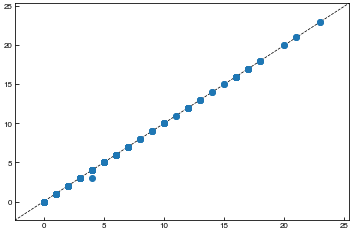

In [144]:
ts = [1, 15, 31]
x, y = [], []
fig, ax = plt.subplots()
for medium, wells in shared.medium_to_well_map.items():
    for well, vitro_set in wells:
        p_counts = {p:0 for p in ts}
        for mut, passage_freqs in filtered_well_mutations[medium][well].items():
            for p in ts:
                if p in passage_freqs: p_counts[p] += 1
        x.extend([p_counts[p] for p in ts])

        p_counts = {p:0 for p in ts}
        for mut, passage_freqs in wells_permuted_mutations_map[medium][well].items():
            for p in ts:
                if p in passage_freqs: p_counts[p] += 1
        y.extend([p_counts[p] for p in ts])

        # x.append( len(merged_map[medium][well]) )
        # y.append( len(wells_permuted_mutations_map[medium][well]) )
ax.scatter(x, y)
util.plot_diagonal(ax)

In [132]:
def pare_well_mutations_map(well_mutations_map):
    pared_well_mutations = {medium:{well:{} for (well, invitro_set) in shared.medium_to_well_map[medium]} \
                          for medium in shared.medium_to_well_map.keys()}
    for medium, wells in shared.medium_to_well_map.items():
        for well, vitro_set in wells:
            well_muts = well_mutations_map[medium][well].items()
            for mut, passage_freqs in well_muts:
                # if mut[1] in ['JC', 'MC']:
                #     continue
                # if mut[1] not in ['JC', 'MC'] and mut[-1] == 'True':
                #     continue
                if len(passage_freqs) > 1 and 31 in passage_freqs and 15 in passage_freqs:
                    if 1 in passage_freqs:# and passage_freqs[1] > 0.1:
                        continue

                    pared_well_mutations[medium][well][mut] = passage_freqs

                # if 31 in passage_freqs or 15 in passage_freqs:
                #     pared_well_mutations[medium][well][mut] = passage_freqs

                # gene = mut[2]
                # if gene not in mutation_dict:
                #     mutation_dict[gene] = {}
                # if medium not in mutation_dict[gene]:
                #     mutation_dict[gene][medium] = {}
                # mutation_dict[gene][medium][well] = (mut, passage_freqs)


    return pared_well_mutations
pared_well_mutations = pare_well_mutations_map(filtered_well_mutations)
pared_well_permuted_mutations = pare_well_mutations_map(wells_permuted_mutations_map)




In [145]:

true_count = 0
permuted_count = 0

for medium, wells in shared.medium_to_well_map.items():
        for well, vitro_set in wells:
            true_count += len(filtered_well_mutations[medium][well])
            permuted_count += len(wells_permuted_mutations_map[medium][well])

print(true_count)
print(permuted_count)

635
1108


In [120]:
FOCAL_MEDIA = ['glucose', 'iron', 'vitafiber', 'bioecolians', 'avantafiber', 'wako', 'UMich-01', 'ISOT 160120']
FOCAL_MEDIA = ['vitafiber', 'bioecolians', 'avantafiber', 'wako', 'UMich-01']

for medium in shared.medium_to_well_map.keys():
    if medium not in FOCAL_MEDIA: continue

    print(f'\nMEDIUM {medium}')
    for well, vitro_set in shared.medium_to_well_map[medium]:
        # print(vitro_set, well, len( well_mutations_map[medium][well] ) )
        # print(vitro_set, well, len( pared_well_mutations[medium][well] ) )
        print(well, vitro_set, len(pared_well_mutations[medium][well]) )

        for mut, freqs in pared_well_mutations[medium][well].items():
            # if mut[1] != 'SNP': continue
            print('\t\t', mut, freqs)
        # print('>>PERMUTED', well, vitro_set, len(pared_well_permuted_mutations[medium][well]), pared_well_permuted_mutations[medium][well])
        print('\n\n')


MEDIUM vitafiber
p1_A11 invitro_3 2
		 ((5939745, 5943532), 'JC', ('BT4520', 'BT4523'), (1, 1)) {15: (0.400633413, 11), 31: (0.539386651, 13)}
		 ((5941889, 5942810), 'JC', ('BT4522', 'BT4523'), (-1, -1)) {15: (0.481171548, 10), 31: (0.433281005, 6)}



p1_B11 invitro_6 18
		 (4502896, 'SNP', 'BT3490/BT3491', '-/+', 'putative ATPase/glutaminase A', 59, 'A->G', 'intergenic (-365/-70)', '') {15: 0.451641083, 31: 0.379294872}
		 (4502899, 'SNP', 'BT3490/BT3491', '-/+', 'putative ATPase/glutaminase A', 59, 'T->C', 'intergenic (-368/-67)', '') {15: 0.451677799, 31: 0.37928915}
		 (4502903, 'SNP', 'BT3490/BT3491', '-/+', 'putative ATPase/glutaminase A', 59, 'C->T', 'intergenic (-372/-63)', '') {15: 0.393140316, 31: 0.366661072}
		 (4502905, 'SNP', 'BT3490/BT3491', '-/+', 'putative ATPase/glutaminase A', 59, 'T->A', 'intergenic (-374/-61)', '') {15: 0.407381058, 31: 0.367169857}
		 (4502908, 'SNP', 'BT3490/BT3491', '-/+', 'putative ATPase/glutaminase A', 59, 'T->C', 'intergenic (-377/-58)', 

KstestResult(statistic=0.7844827586206896, pvalue=7.887571608246186e-51)
Ttest_indResult(statistic=-15.915844142715544, pvalue=5.2931844151086336e-39)


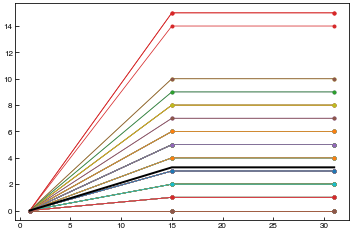

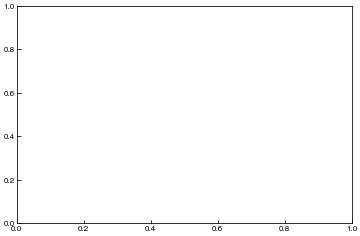

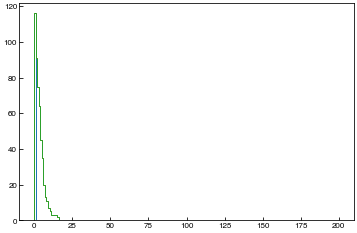

In [121]:
## NUMBER OF DETECTED MUTANTS OVER TIME

fig, ax = plt.subplots()

x = [1, 15, 31]
mut_count_master = {1:[], 15:[], 31:[]}

scatter_fig, scatter_ax = plt.subplots()

def pare_well_mutations_map(well_mutations_map):
    pared_well_mutations = {medium:{well:{} for (well, invitro_set) in shared.medium_to_well_map[medium]} \
                          for medium in shared.medium_to_well_map.keys()}
    for medium, wells in shared.medium_to_well_map.items():
        for well, vitro_set in wells:
            well_muts = well_mutations_map[medium][well].items()
            for mut, passage_freqs in well_muts:
                if len(passage_freqs) > 0:
                    pared_well_mutations[medium][well][mut] = passage_freqs
    return pared_well_mutations

# pared_well_mutations = pare_well_mutations_map(merged_map)
# well_mutations = merged_map
for medium in shared.medium_to_well_map.keys():
    for well, vitro_set in shared.medium_to_well_map[medium]:
        # well_mutations = well_mutations_map[medium][well]
        well_mutations = merged_map[medium][well]

        n_muts = {p:0 for p in x}
        for mut, passage_freqs in well_mutations.items():
            for p in passage_freqs.keys():
                n_muts[p] += 1
        y = [n_muts[p] for p in x]

        for i, p in enumerate(x):
            random_map = {p:p1 for p, p1 in zip(x, rnd.permutation(x))}
            try:
                # mut_count_master[p].append(n_muts[random_map[p]])
                mut_count_master[p].append(n_muts[p])
                scatter_ax.scatter( well_coverage_map[(well, p)], n_muts[p], color = KELLY_COLORS[i])
            except: continue
        ax.plot(x, y, marker='.')
# ax.set_yscale('log')

ax.plot( x, [np.mean(mut_count_master[p]) for p in x], color='black', lw=2)

# scatter_ax.set_yscale('log')
# scatter_ax.set_xscale('log')
fig, ax = plt.subplots()
for p in x:
    # ax.hist(mut_count_master[p], bins = np.linspace(100, 10000, 10001-100), histtype='step', cumulative=-1)
    # ax.hist(mut_count_master[p], bins = np.linspace(0, 80, 81), histtype='step', cumulative=-1)
    ax.hist(mut_count_master[p], bins = np.linspace(0, 200, 201), histtype='step', cumulative=-1)
# ax.set_xscale('log')

import scipy.stats
# print( scipy.stats.stats.kstest( np.log(mut_count_master[1]), np.log(mut_count_master[15] + mut_count_master[31])) )
# print( scipy.stats.ttest_ind( np.log(mut_count_master[1]), np.log(mut_count_master[15] + mut_count_master[31]), equal_var=False))

print( scipy.stats.stats.kstest( mut_count_master[1], mut_count_master[15] + mut_count_master[31]) )
print( scipy.stats.ttest_ind( mut_count_master[1], mut_count_master[15] + mut_count_master[31], equal_var=False))



In [430]:
# fig, ax = plt.subplots()
def loci_specific_to_kmedia(well_mutations_map):
    locus_dict = {}

    multihit_count = 0
    for medium, wells in shared.medium_to_well_map.items():
        for well, vitro_set in wells:
            well_muts = well_mutations_map[medium][well].items()

            gene_set = set()
            for mut, passage_freqs in well_muts:
                gene = mut[2]
                if mut_type[1] in ['MC', 'JC'] or gene in gene_set:
                    continue

                if 1 in passage_freqs or 31 not in passage_freqs:
                    continue
                # if 31 not in passage_freqs and 15 not in passage_freqs:
                #     continue

                gene_set.add(gene)
                if gene not in locus_dict:
                    locus_dict[gene] = {}
                if medium not in locus_dict[gene]:
                    locus_dict[gene][medium] = []
                locus_dict[gene][medium].append((well, vitro_set, passage_freqs))

    for gene, medium_wells in list(locus_dict.items()):
        if len(medium_wells) == 1:
            key = list(medium_wells.keys())[0]
            if len(medium_wells[key]) == 1:
                del locus_dict[gene]
                continue
            else:
                print(gene, key, medium_wells[key])
                multihit_count += 1
        else:
            del locus_dict[gene]

    # for gene, medium_wells in list(locus_dict.items()):
    #     if len(medium_wells) != 5:
    #         del locus_dict[gene]
    #     else:

    #         multihit_count += 1
    # print(multihit_count)
    print(len(locus_dict))



wells_permuted_mutations_map = permute_mutations_among_wells(merged_map)

loci_specific_to_kmedia(merged_map)
loci_specific_to_kmedia(wells_permuted_mutations_map)

BT2740 iron [('p1_A10', 'invitro_2', {31: 1.0}), ('p1_B10', 'invitro_5', {31: 0.423699379})]
BT4615 iron [('p1_A10', 'invitro_2', {31: 1.0}), ('p1_B10', 'invitro_5', {31: 0.28869009})]
BT1813 vitafiber [('p1_A11', 'invitro_3', {31: 0.166587353}), ('p1_D11', 'invitro_6', {31: 0.15380764})]
('BT0867-BT0868', 'BT0867-BT0868') lactose [('p1_F2', 'invitro_5', {31: 0.417928528}), ('p1_G2', 'invitro_2', {31: 0.739549839})]
('BT3090-BT3091', 'BT3134') bioecolians [('p2_B2', 'invitro_5', {15: 0.358732738, 31: 0.69416499}), ('p2_D2', 'invitro_5', {31: 0.892722372})]
('BT1763', 'BT1763') prebiotin [('p2_A3', 'invitro_3', {31: 0.546354339}), ('p2_C3', 'invitro_3', {31: 0.737827}), ('p2_D3', 'invitro_6', {31: 0.556701031})]
BT3224 prebiotin [('p2_B3', 'invitro_6', {31: 0.111054897}), ('p2_C3', 'invitro_3', {31: 0.104559898})]
BT1954 precticx [('p2_B9', 'invitro_4', {31: 0.119717121}), ('p2_D9', 'invitro_4', {31: 0.107133865})]
BT0532 LC742 [('p2_A10', 'invitro_2', {31: 0.113725185}), ('p2_C10', 'in

/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_41364/3456221509.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  muts_per_timepoint[p] = list(rnd.permutation(muts_per_timepoint[p]))


In [151]:
for gene in sorted(gene_hits_map.keys()):
    gene_hits = gene_hits_map[gene]
    if len(gene_hits) == 1:
        for medium, well_hits in gene_hits.items():
            unique_wells = { (well_hit[0], well_hit[1]) for well_hit in well_hits }
            if len(unique_wells) > 1:
                if gene in shared.gene_description:
                    gene_desc = shared.gene_description[gene]
                else:
                    gene_desc = 'intergenic'
                print(medium, gene, gene_desc, len(unique_wells), unique_wells)




glucose BT0066-BT0067 intergenic 2 {('p1_A1', 'invitro_1'), ('p1_B1', 'invitro_4')}
UMich-02b BT0272 SusC homolog 2 {('p2_H1', 'invitro_4'), ('p2_F1', 'invitro_4')}
maltodextrin BT0648 molybdopterin biosynthesis protein 2 {('p2_A5', 'invitro_1'), ('p2_B5', 'invitro_4')}
UMich-01 BT0822 putative metallo-beta-lactamase superfamily hydrolase 2 {('p2_D1', 'invitro_4'), ('p2_C1', 'invitro_1')}
vitagos BT0889 DNA polymerase III-like, delta subunit 2 {('p2_C7', 'invitro_3'), ('p2_A7', 'invitro_3')}
bioecolians BT1414 conserved hypothetical protein 2 {('p2_B2', 'invitro_5'), ('p2_C2', 'invitro_2')}
promitor BT1940 conserved hypothetical protein 2 {('p2_D6', 'invitro_5'), ('p2_B6', 'invitro_5')}
precticX BT1954 putative surface layer protein 2 {('p2_B9', 'invitro_4'), ('p2_D9', 'invitro_4')}
LC742 BT2417 putative permease 2 {('p2_D10', 'invitro_5'), ('p2_C10', 'invitro_2')}
precticX BT2499 peptide methionine sulfoxide reductase msrA/msrB 2 {('p2_C9', 'invitro_1'), ('p2_D9', 'invitro_4')}
ISOT 1

In [123]:
gene_hits_to_unique_wells_map = {gene:{} for gene in gene_hits_map.keys()}
for gene, gene_hits in gene_hits_map.items():
    for medium, well_hits in gene_hits.items():
        unique_wells = list( { well_hit[0] for well_hit in well_hits } )

        gene_hits_to_unique_wells_map[gene][medium] = unique_wells

In [140]:
import numpy as np; rnd = np.random.default_rng()
def permute_gene_hits(gene_hits_to_unique_wells_map):
    gene_hit_counts = {gene:0 for gene in gene_hits_to_unique_wells_map.keys()}
    available_muts = []

    for gene, gene_hits in gene_hits_to_unique_wells_map.items():
        for medium, unique_wells in gene_hits.items():
            for unique_well in unique_wells:
                gene_hit_counts[gene] += 1
                available_muts.append( (gene, unique_well) )

    permuted_muts = list(rnd.permutation(available_muts))
    permuted_gene_to_wells_map = {gene:{} for gene in gene_hit_counts.keys()}


    for gene, counts in gene_hit_counts.items():
        for _ in range(counts):
            (medium, well) = permuted_muts.pop()
            if medium not in permuted_gene_to_wells_map[gene]:
                permuted_gene_to_wells_map[gene][medium] = []
            permuted_gene_to_wells_map[gene][medium].append(well)
    return permuted_gene_to_wells_map

permuted_gene_to_wells = permute_gene_hits(gene_hits_to_unique_wells_map)



0.0 3.0 6.0


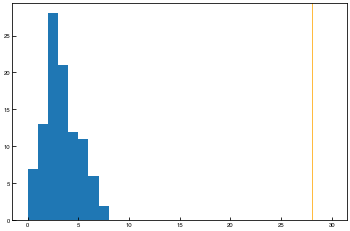

In [150]:
unique_hits_lst = []

for _ in range(100):
    unique_hits = 0
    permuted_gene_to_wells = permute_gene_hits(gene_hits_to_unique_wells_map)

    for gene in sorted(permuted_gene_to_wells.keys()):
        gene_hits = permuted_gene_to_wells[gene]
        if len(gene_hits) == 1:
            for medium, well_hits in gene_hits.items():
                unique_wells = { well_hit for well_hit in well_hits }
                if len(unique_wells) > 1:
                    if gene in shared.gene_description:
                        gene_desc = shared.gene_description[gene]
                    else:
                        gene_desc = 'intergenic'
                    unique_hits += 1
                    # print(gene, gene_desc, medium, len(unique_wells), well_hits)

    unique_hits_lst.append(unique_hits)

fig, ax = plt.subplots()
ax.hist(unique_hits_lst, bins=np.linspace(0, 30, 31))
print( np.percentile(unique_hits_lst, 2.5), np.percentile(unique_hits_lst, 50), np.percentile(unique_hits_lst, 97.5))
ax.axvline(28, color='orange')